In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import diagsvd
import matplotlib.pyplot as plt
import os
os.chdir('/Users/sosuke/Downloads')

$$
f(x_{1},\dots,x_{100})=\sum\nolimits_{j=1}^{100}c_{j}x_{j}-\sum\nolimits_{i=1}
^{500}\log\left(  b_{i}-\sum\nolimits_{j=1}^{100}a_{ij}x_{j}\right)  .
$$

$$\nabla f(x_1,...,x_{100}) =
\begin{bmatrix} c_1 + \sum_{i=1}^{500} \frac{a_{i1}}{b_i - \sum_{j=1}^{100} a_{ij} x_j} \\ c_2 + \sum_{i=1}^{500} \frac{a_{i2}}{b_i - \sum_{j=1}^{100} a_{ij} x_j} \\ \vdots \\ c_{100} + \sum_{i=1}^{500} \frac{a_{i100}}{b_i - \sum_{j=1}^{100} a_{ij} x_j} \end{bmatrix} = c+ \begin{bmatrix} \sum_{i=1}^{500} \frac{a_{i1}}{b_i - \sum_{j=1}^{100} a_{ij} x_j} \\ \sum_{i=1}^{500} \frac{a_{i2}}{b_i - \sum_{j=1}^{100} a_{ij} x_j} \\ \vdots \\ \sum_{i=1}^{500} \frac{a_{i100}}{b_i - \sum_{j=1}^{100} a_{ij} x_j} \end{bmatrix}$$

$$\nabla^2 f(x_1,...,x_{100}) =
\begin{bmatrix} \sum_{i=1}^{500} \frac{a_{i1}^2}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} & \sum_{i=1}^{500} \frac{a_{i1}a_{i2}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} & \ldots & \sum_{i=1}^{500} \frac{a_{i1}a_{i100}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2}\\ \sum_{i=1}^{500} \frac{a_{i2}a_{i1}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} & \sum_{i=1}^{500} \frac{a_{i2}^2}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} & \ldots & \sum_{i=1}^{500} \frac{a_{i2}a_{i100}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} \\ \vdots & \vdots & \ddots & \vdots \\ \sum_{i=1}^{500} \frac{a_{i1}a_{i100}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} & \sum_{i=1}^{500} \frac{a_{i2}a_{i100}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} & \ldots & \sum_{i=1}^{500}  \frac{a_{i100}a_{i100}}{(b_i - \sum_{j=1}^{100} a_{ij} x_j)^2} \end{bmatrix}$$

In [7]:
def objectivefun(A, b, c, x):
    '''
    Given a matrix A, vector b, vector c, calculate the value of the objective function at x
    '''
    f = np.dot(c, x)
    for i in range(500):
        if b[i] - np.dot(A[i, :], x) <= 0: # Avoid -inf for negative values
            f+=10000000000
        else:
            f -= np.log(b[i] - np.dot(A[i, :], x))
    return f

def objectivegradient(A, b, c, x):
    '''
    Given a matrix A, vector b, vector c, calculate the value of the gradient of the objective function at x
    '''
    
    g = np.copy(c)

    for i in range(500):
        den = np.dot(A[i, :], x)
        for j in range(100):
            g[j] += A[i,j]/(b[i] - den)
    return g

def objectivehessian(A, b, c, x):
    '''
    Given a matrix A, vector b, vector c, calculate the value of the hessian of the objective function at x
    '''
    h = np.zeros((100, 100))
    for i in range(500):
        den = np.dot(A[i, :], x)
        for k in range(100):
            for j in range(100):
                h[j, k] += A[i,j]*A[i,k]/((b[i] - den)**2)
    return h

In [8]:
def newton(A, b, c, cp, rho, x0, a0, eps, search=True):
    '''
    Given a matrix A, vector b, vector c, line search parameters (cp and rho), starting point x0, 
    initial step size a0, and tolerance eps, whether to do line search (boolean),
    find a global minimum to the given objective function using Newton's method.
    '''
    
    x = np.copy(x0) # Initialize x
    x_array = [np.copy(x)] # Store x0
    k = 0 # Initialize number of steps
    
    while True: 
        hes_inv = np.linalg.inv(objectivehessian(A, b, c, x))
        grad = objectivegradient(A, b, c, x)
        p = - np.dot(hes_inv, grad)
        lam_sq = np.dot(np.dot(np.transpose(grad), hes_inv), grad)
        if lam_sq/2 <= eps:
            break
        alpha = a0 # Initialize step size
        if search==True:
            while objectivefun(A, b, c, x+alpha*p) > objectivefun(A, b, c, x) + cp*alpha*np.dot(grad, p): # Armijo not satisfied
                alpha = rho*alpha # Update alpha
            
        k += 1 # Update step size
        x = x + alpha*p # Update x
        x_array = np.append(x_array, [x], axis=0) # Store new x
        
        
        if k == 15: # Maximum iterations
            print('Maximum iteration reached')
            break
    return x_array
    

In [9]:
## Generate random example

a0 = 1 # initial step size 

# Set seed for reproducibility

np.random.seed(1)
A = np.random.randn(500,100)
x0 = np.random.randn(100)
c = np.random.randn(100)

# Generate b so that x satisfies the constraint

b = np.zeros(500)
for i in range(500):
    b[i] = np.dot(A[i,:], x0) +10*np.random.rand(1)

In [10]:
# Set Hyperparameters

#cp_list = np.array([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9])
cp_list = [0.25 , 0.75]
#rho_list = np.array([0.05 , 0.25, 0.5, 0.75, 0.95])
rho_list = [0.25, 0.75]
#eps_list = np.array([10**(-3), 10**(-5) , 10**(-8)])
eps_list = [10**(-3), 10**(-5)]

In [11]:
x_error_list_stp = [] # list that stores errors and parameters
x_error_list_new = [] # list that stores errors and parameters

# Hyperparameter tuning

for cp_p in cp_list:
    for rho_p in rho_list:
        for eps_p in eps_list:
            
            # Newton's method
            x_newton_tune = newton(A, b, c, cp_p, rho_p, x0, a0, eps_p)
            x_plot_newton_tune = np.zeros(x_newton_tune.shape[0])
            
            #  Calculate log error of Newton
            for i in range(x_newton_tune.shape[0]):
                x_plot_newton_tune[i] = np.log(objectivefun(A, b, c, x_newton_tune[i]) - objectivefun(A, b, c, x_newton_tune[-1])+0.0001)
            x_error_list_new.append((x_plot_newton_tune, cp_p, rho_p, eps_p))

Maximum iteration reached
Maximum iteration reached
Maximum iteration reached
Maximum iteration reached


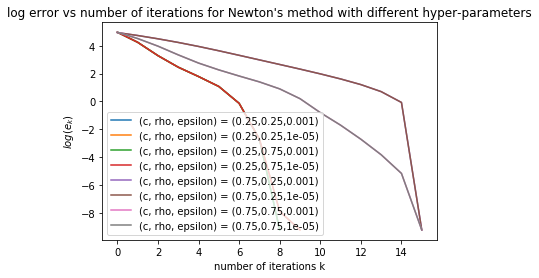

In [12]:
for error in x_error_list_new:
    plt.plot(error[0], label='(c, rho, epsilon) = ({},{},{})'.format(error[1], error[2], error[3]))
plt.xlabel('number of iterations k') 
plt.ylabel('$log(e_k)$') 
plt.title("log error vs number of iterations for Newton's method with different hyper-parameters") 
plt.legend()
plt.show() 

$(c, \rho, \epsilon) = (0.25, 0.75, 10^{-3})$ gives the fastest convergence for Newton's method.